## Import Statements

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from scipy import stats
import csv
import itertools

c:\Users\jslon\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Funtions

In [2]:
def GetKeithly(filename):
  try:
    df = pd.read_csv(filename, skiprows=list(range(0,8)),encoding='latin-1')
    vals = df['Reading'].values
    return vals
  except:
    print(f'Error reading {filename}')

def GetKeithTimes(filename):
  try:
    df = pd.read_csv(filename, skiprows=list(range(0,8)),encoding='latin-1')
    vals = df['Relative Time'].values
    return vals
  except:
    print(f'Error reading {filename}')

def GetKeysight(filename):
  try:
    df = pd.read_csv(filename, skiprows=list(range(0,1)),encoding='latin-1')
    vals = df['Reading'].values
    return vals
  except:
    print(f'Error reading {filename}')

def QHRead(ver: str, QHnum = '1'):
  PWRvals = np.arange(-40,10,1)
  Keithfile = 'QH_'+ QHnum + '-4_' + ver + '.csv'
  Keyfile = 'QH_' + QHnum + '-2_' + ver + '.csv'
  Keithvals = GetKeithly(Keithfile)
  Keyvals = GetKeysight(Keyfile)
  vals_1_4 = []
  vals_1_2 = []
  for i in range(1,51):
    vals_1_4.append(Keithvals[(i-1)*1000:i*1000])
    vals_1_2.append(Keyvals[(i-1)*1000:i*1000])
  return PWRvals, vals_1_4, vals_1_2

lfunc647 = lambda x: 1.066*x - 0.00006203
efunc647 = lambda x: -17.18*np.exp(-0.062*x) + 17.18
sfunc647 = lambda x: 0.02852*np.sin(38.03*x + 5.907) + 0.01046

corrfunc = lambda v647: efunc647(v647)

def UnitPrefix(val):
  prefixes = {9:'G', 6:'M', 3:'k', 0:'', -3:'m', -6:'μ', -9:'n'}
  exp1 = 3*(np.log10(val)//3)
  uscale = 10**exp1
  return prefixes[exp1], uscale

def detRead(ver: str, PWRvals: np.ndarray, detnum = '646', sweepnum='1'):
  Keithfile = detnum + 'Sweep' + sweepnum + '_' + ver + '.csv'
  Keithvals = GetKeithly(Keithfile)
  detvals = []
  for i in range(1,51): #Fix
    detvals.append(Keithvals[(i-1)*1000:i*1000])
  return detvals

def PassthroughRead(ver: str, PWRvals: np.ndarray):
  Keithfile = 'QHPassthrough' + ver + '.csv'
  Keithvals = GetKeithly(Keithfile)
  Passvals = []
  for i in range(1,51): #Fix
    Passvals.append(Keithvals[(i-1)*1000:i*1000])
  return Passvals

def CombineRead(ver: str, PWRvals: np.ndarray):
  Keithfile = 'Combine' + ver + '.csv'
  Keithvals = GetKeithly(Keithfile)
  Combvals = []
  for i in range(1,51): #Fix
    Combvals.append(Keithvals[(i-1)*1000:i*1000])
  return Combvals

def SeriesDuration(ver: str, PWR: str):
  Filename = '646_' + PWR + '_' + 'TimeSeries' + ver + '.csv'
  t1 = GetKeithTimes(Filename)
  duration = (t1[-1]-t1[0])
  hours = duration//3600
  minutes = (duration%3600)//60
  seconds = duration%60
  print(f'{PWR}dBm {ver} lasted {round(hours)}hr {round(minutes)}min {round(seconds)}s')
  return duration

def SeriesRead(ver: str, PWR: str, detnum: str, machine: str, slice_size: int):
  Filename = detnum + '_' + PWR + '_' + 'TimeSeries' + ver + '.csv'
  if machine == 'Keithly':
    Series = GetKeithly(Filename)
  elif machine == 'Keysight':
    Series = GetKeysight(Filename)
  else:
    raise ValueError('Machine musy be either Keithly or Keysight')
  n = len(Series)
  Sliced_Vals = []
  for i in range(0,n,slice_size):
    Sliced_Vals.append(1000*np.abs(Series[i:i+slice_size]))
  return Sliced_Vals

def SeriesPlot(ver: str, PWR: str, sampling_freq: int, Slice_Size: int, Scatter_Slice: int, n: int, aperture: float, figsize=(20,9), alpha=0.05, size=4, normalized=False, timescale='seconds'):
  if timescale == 'seconds':
    xscale = 1
    tlabel = 'Time(s)'
  elif timescale == 'minutes':
    xscale = 60
    tlabel = 'Time(min)'
  elif timescale == 'hours':
    xscale = 3600
    tlabel = 'Time(hr)'
  else:
    raise ValueError('timescale must be either seconds, minutes, or hours')

  S1a = np.array(SeriesRead(ver,PWR,'646','Keithly',Slice_Size))
  S2a = np.array(SeriesRead(ver,PWR,'647','Keysight',Slice_Size))
  Series_646 = np.array([np.mean(valarray) for valarray in S1a])
  Series_647 = np.array([np.mean(valarray) for valarray in S2a])
  total = Series_646 + Series_647
  frac646 = 100*Series_646/total
  frac647 = 100*Series_647/total

  S1s = np.array(SeriesRead(ver,PWR,'646','Keithly',Scatter_Slice))
  S2s = np.array(SeriesRead(ver,PWR,'647','Keysight',Scatter_Slice))
  sSeries_646 = np.array([np.mean(valarray) for valarray in S1s])
  sSeries_647 = np.array([np.mean(valarray) for valarray in S2s])
  stotal = sSeries_646 + sSeries_647
  sfrac646 = 100*sSeries_646/stotal
  sfrac647 = 100*sSeries_647/stotal

  xvals = np.arange(0,n,Slice_Size)/(sampling_freq*xscale)
  xvals_scatter = np.arange(0,n,Scatter_Slice)/(sampling_freq*xscale)

  if normalized:
    norm = 100/stotal.max()
  else:
    norm = 1

  normdict = {True:'Is Normalized', False:'Is Not Normalized'}

  total = total*norm
  Series_646 = Series_646*norm
  Series_647 = Series_647*norm

  stotal = stotal*norm
  sSeries_646 = sSeries_646*norm
  sSeries_647 = sSeries_647*norm

  bound1 = np.array([sSeries_646,sSeries_647])
  bound2 = np.array([sfrac646,sfrac647])
  bound3 = stotal

  fig1 = plt.figure(figsize=(20,9))
  alpha1 = 0.05
  size1 = 4

  prefix, uscale = UnitPrefix(aperture)

  print(f'There are {n} Points In Total')
  print(f'The Sampling Rate is {sampling_freq}Hz')
  print(f'Aperture is {int(aperture//uscale)} {prefix}s')
  print(f'Line Plots Averaging Every {Slice_Size} Points')
  print(f'Scatter Plots Averaging Every {Scatter_Slice} Points')
  print(f'Timescale units are {timescale}')
  print(f'Signal {normdict[normalized]}')
  print('')

  plt.subplot(2, 3, 1)
  plt.plot(xvals,Series_646,'-b',label=f'det646: {PWR}dBm')
  plt.plot(xvals,Series_647,'-r',label=f'det647: {PWR}dBm')
  plt.scatter([0,0],[bound1.min(),bound1.max()],alpha=0)
  plt.xlabel(tlabel); plt.ylabel('Detector Voltage(mV)')
  plt.title(f'Detector Voltage vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.subplot(2, 3, 2)
  plt.plot(xvals,frac646,'-b',label=f'det646: {PWR}dBm')
  plt.plot(xvals,frac647,'-r',label=f'det647: {PWR}dBm')
  plt.scatter([0,0],[bound2.min(),bound2.max()],alpha=0)
  plt.xlabel(tlabel); plt.ylabel('Power Fraction')
  plt.title(f'Power Fraction vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.subplot(2, 3, 3)
  plt.plot(xvals,total,'-g',label=f'Total: {PWR}dBm')
  plt.scatter([0,0],[bound3.min(),bound3.max()],alpha=0)
  plt.xlabel(tlabel); plt.ylabel('Total Power')
  plt.title(f'Total Power vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.subplot(2, 3, 4)
  plt.scatter(xvals_scatter,sSeries_646,c='b',s=size,alpha=alpha)
  plt.scatter(xvals_scatter,sSeries_647,c='r',s=size,alpha=alpha)
  plt.plot([],[],'.b',label=f'det646: {PWR}dBm'); plt.plot([],[],'.r',label=f'det647: {PWR}dBm')
  plt.xlabel(tlabel); plt.ylabel('Detector Voltage(mV)')
  plt.title(f'Detector Voltage vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.subplot(2, 3, 5)
  plt.scatter(xvals_scatter,sfrac646,c='b',s=size,alpha=alpha)
  plt.scatter(xvals_scatter,sfrac647,c='r',s=size,alpha=alpha)
  plt.plot([],[],'.b',label=f'det646: {PWR}dBm'); plt.plot([],[],'.r',label=f'det647: {PWR}dBm')
  plt.xlabel(tlabel); plt.ylabel('Power Fraction')
  plt.title(f'Power Fraction vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.subplot(2, 3, 6)
  plt.scatter(xvals_scatter,stotal,c='g',s=size,alpha=alpha)
  plt.plot([],[],'.g',label=f'Total: {PWR}dBm')
  plt.xlabel(tlabel); plt.ylabel('Total Power')
  plt.title(f'Total Power vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.tight_layout()
  return

def PhaseNoisePlot(ver: str, PWR: str, errmax = 'None', Slice_Size=1000, aperture=50e-6, figsize=(20,9), normalized=True):
  Micro = np.arange(0,1025,25)

  Sliced_Slot2 = SeriesRead(ver, PWR, '647', 'Keysight', Slice_Size)
  Sliced_Slot4 = SeriesRead(ver, PWR, '646', 'Keithly', Slice_Size)

  Vals_Slot2m = np.array([np.mean(valarray) for valarray in Sliced_Slot2])
  Vals_Slot4m = np.array([np.mean(valarray) for valarray in Sliced_Slot4])

  Vals_Slot4p = np.array([100*np.std(valarray)/np.mean(valarray) for valarray in Sliced_Slot4])
  Vals_Slot2p = np.array([100*np.std(valarray)/np.mean(valarray) for valarray in Sliced_Slot2])

  if normalized:
    norm = 100/max([Vals_Slot2m.max(),Vals_Slot4m.max()])
  else:
    norm = 1

  normdict = {True:'Is Normalized', False:'Is Not Normalized'}

  prefix, uscale = UnitPrefix(aperture)

  print(f'Aperture is {int(aperture//uscale)} {prefix}s')
  print(f'{Slice_Size} Points Per Meter Value')
  print(f'Signal {normdict[normalized]}')
  print('')

  fig1 = plt.figure(figsize=figsize)

  plt.subplot(1, 2, 1)
  plt.plot(Micro,Vals_Slot2m*norm,'-b',label=f'det647: Slot 1-2')
  plt.plot(Micro,Vals_Slot4m*norm,'-r',label=f'det646: Slot 1-4')
  plt.plot(Micro,Vals_Slot2m*norm,'.b')
  plt.plot(Micro,Vals_Slot4m*norm,'.r')
  plt.xlabel('Micrometer Reading'); plt.ylabel('Detector Voltage(mV)')
  plt.title(f'Detector Voltage vs Micrometer Reading for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.subplot(1, 2, 2)
  plt.plot(Micro,Vals_Slot2p,'-b',label=f'det647: Slot 1-2')
  plt.plot(Micro,Vals_Slot4p,'-r',label=f'det646: Slot 1-4')
  plt.plot(Micro,Vals_Slot2p,'.b')
  plt.plot(Micro,Vals_Slot4p,'.r')
  plt.xlabel('Micrometer Reading'); plt.ylabel('Percent Error')
  if errmax != 'None':
    plt.ylim(0,min([errmax,1.1*max([Vals_Slot2p.max(),Vals_Slot4p.max()])]))
  plt.title(f'Percent Error vs Micrometer Reading for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.tight_layout(); plt.show()
  return

## Phase Noise Cont.

In [3]:
#Try different powers, attenuation and not attenuation, try amplification circuit, source B, and different detectors, maybe try the spectrum analyzer for some power measurements
#Maybe look at each source output in spectrum analyzer

In [4]:
#Try amplification circuit, make sure detectors are predictable in this range without attenuation,
#Checks changing digit readings, try amplification circuit.

In [5]:
#Try mixing amplification and attenuation mix

In [6]:
Normv7 = True

In [7]:
#v13 20dBm has no attenuation, starts 10:00 7/26

Same as prior notebook

Aperture is 50 μs
1000 Points Per Meter Value
Signal Is Not Normalized



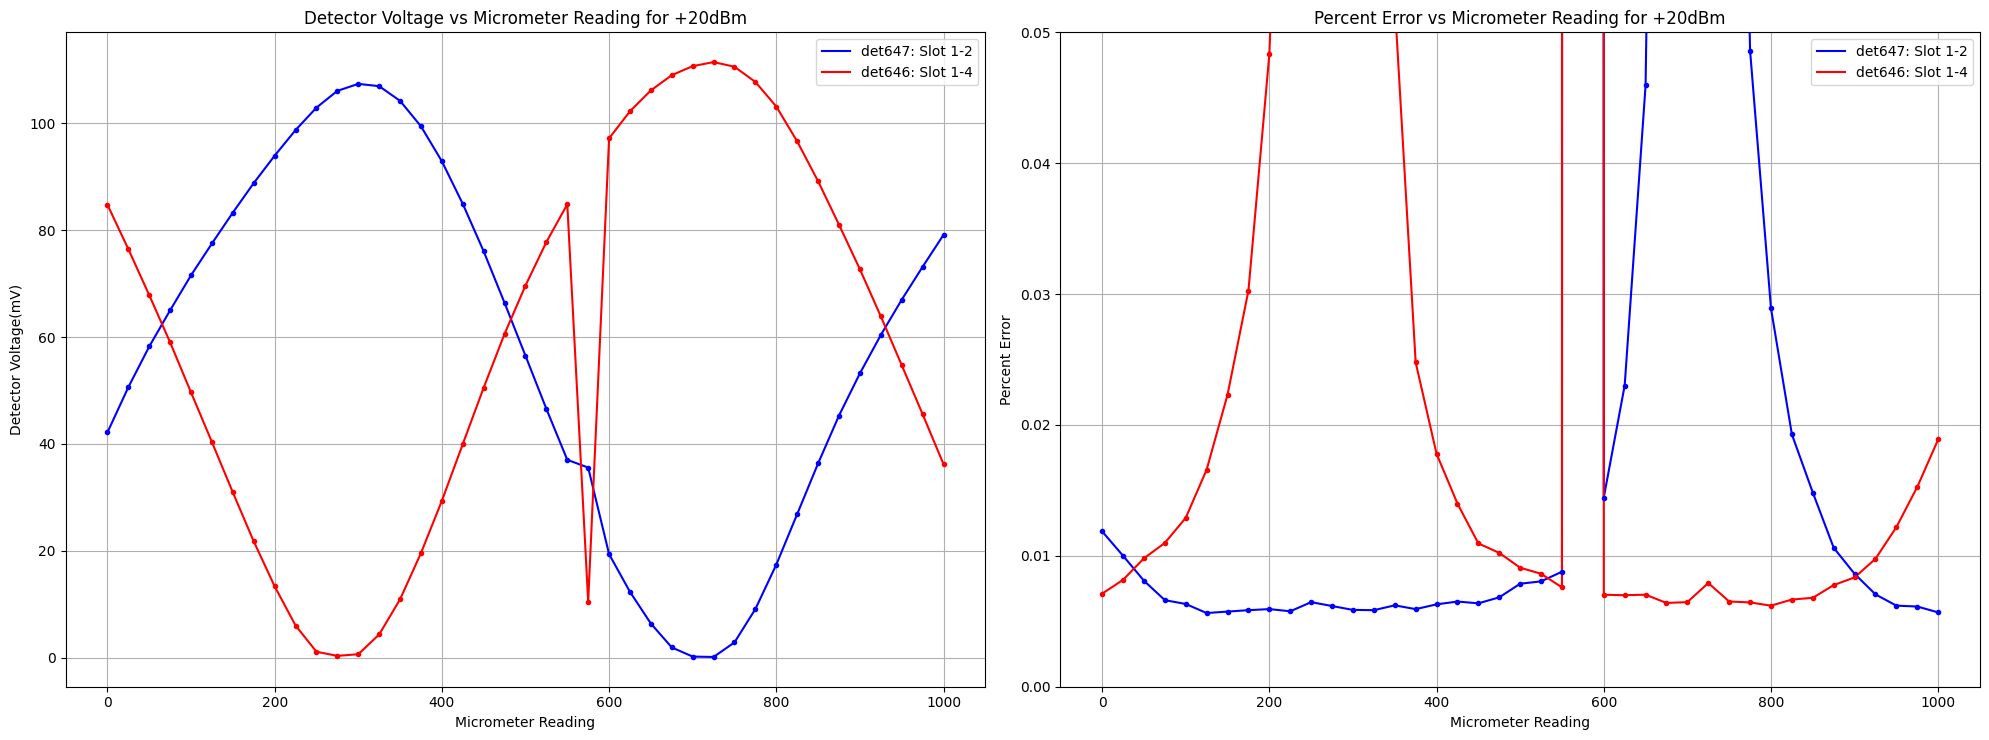

In [8]:
PhaseNoisePlot(ver='v13', PWR='+20', errmax=0.05, Slice_Size=1000, aperture=50e-6, figsize=(20,7.5), normalized=False)

## Automated Detector Voltage Curves

Here I am generating tables to use with the microwave source to change the output power automatically, performing a sweep

In [9]:
#Check max is 500
#Check Power is not greater than 20

In [10]:
def GetPowerTable(ver: str, Powers: tuple, Mult: int, sample_freq=100, Tstep=10000, Freq=6800):
  Powervals = list(itertools.chain.from_iterable(itertools.repeat(i, Mult) for i in np.arange(Powers[0], Powers[1]+Powers[2],Powers[2])))
  N = len(Powervals); Stepvals = list(np.arange(0,N))
  FreqA = [Freq]*N

  duration = N*(Tstep//1000)
  hours = duration//3600
  minutes = (duration%3600)//60
  seconds = duration%60

  if N > 500:
    raise ValueError(f'Cannot have more than 500 steps: {N}')
  print(f'The table has {N//Mult} Power Values')
  print(f'The table has {Mult} Steps Per Value')
  print(f'The table has {Mult*sample_freq*Tstep//1000} Points Per Value')
  print(f'The table has {N} Total Steps')
  print(f'The table will last {round(hours)}hr {round(minutes)}min {round(seconds)}s')

  PreT = [Stepvals, FreqA, Powervals]
  PostT = list(zip(*PreT))

  filename = 'PowerTable' + ver + '.csv'

  with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(PostT)
  return filename

In [11]:
filename = GetPowerTable(ver='v4', Powers=(0,15,0.1), Mult=3, Tstep=10000, Freq=6800)
download = 0
if download:
  files.download(filename)

The table has 151 Power Values
The table has 3 Steps Per Value
The table has 3000 Points Per Value
The table has 453 Total Steps
The table will last 1hr 15min 30s


In [12]:
def PowerSeriesDuration(ver: str, detnum: str):
  Filename = detnum + '_' + 'PowerSeries' + ver + '.csv'
  t1 = GetKeithTimes(Filename)
  duration = (t1[-1]-t1[0])
  hours = duration//3600
  minutes = (duration%3600)//60
  seconds = duration%60
  print(f'det{detnum} {ver} lasted {round(hours)}hr {round(minutes)}min {round(seconds)}s')
  return duration

def PowerSeriesRead(ver: str, detnum: str, machine: str):
  Filename = detnum + '_' + 'PowerSeries' + ver + '.csv'
  if machine == 'Keithly':
    Series = GetKeithly(Filename)
  elif machine == 'Keysight':
    Series = GetKeysight(Filename)
  else:
    raise ValueError('Machine musy be either Keithly or Keysight')
  return Series

def PowerSeriesPlot(ver: str, sampling_freq: int, n: int, aperture: float, info = [0,20,1,18,10], Mod=0, Shift=0, figsize=(20,9), size=4, normalized=False, detectors=[1,1,1,1],):
  normdict = {True:'Is Normalized', False:'Is Not Normalized'}
  prefix, uscale = UnitPrefix(aperture)
  dets = [det for det, flag in zip(['645','646','647','648'],detectors) if flag]
  PWRs = np.arange(info[0],info[1]+info[2],info[2]); PN = len(PWRs)
  PointsPer = info[3]*info[4]*sampling_freq
  if Mod == 0:
    ModPoints = 0
  elif Mod > 0 and Mod < 1:
    ModPoints = PointsPer//2 - int(Mod*PointsPer/2)
  elif Mod >= 1:
    ModPoints = Mod
  Series = []; Maxs = []; SMax = []; SMin = []
  print(f'There are {n} Points In Total')
  print(f'There are {PointsPer} Points Per Value')
  print(f'The Sampling Rate is {sampling_freq}Hz')
  print(f'The Power Range is {info[0]}-{info[1]}dBm')
  print(f'The Power Increment is {info[2]}dBm')
  print(f'The Steps Per Increment is {info[3]}')
  print(f'The Averaging Point Margin is {ModPoints}')
  print(f'The Length of Each Step is {info[4]}s')
  print(f'The Aperture Length is {int(aperture//uscale)} {prefix}s')
  print(f'The Signal {normdict[normalized]}')
  print('')

  for det in dets:
    SR = 1000*np.array(PowerSeriesRead(ver,det,'Keithly')) #Check the lengths versus n
    SR1 = SR[PointsPer-1:2*PointsPer]
    SR1 = SR1[1:] - SR1[:-1]
    StartIndex0 = np.argmax(np.abs(SR1)) + ModPoints - 1 + Shift
    EndIndex0 = np.argmax(np.abs(SR1)) + PointsPer - ModPoints - 1 + Shift
    SRF = np.array([np.mean(np.abs(SR[StartIndex0+PointsPer*i:EndIndex0+PointsPer*i])) for i in range(PN)])
    SRFMax = np.array([np.abs(SR[StartIndex0+PointsPer*i:EndIndex0+PointsPer*i]).max() for i in range(PN)])
    SRFMin = np.array([np.abs(SR[StartIndex0+PointsPer*i:EndIndex0+PointsPer*i]).min() for i in range(PN)])
    Series.append(SRF); Maxs.append(SRF.max()); SMax.append(SRFMax); SMin.append(SRFMin)

  if normalized:
    norm = 100/max(Maxs)
  else:
    norm = 1

  SDict = {det:SRF*norm for det, SRF in zip(dets,Series)}
  SMinDict = {det:SRF*norm for det, SRF in zip(dets,SMin)}
  SMaxDict = {det:SRF*norm for det, SRF in zip(dets,SMax)}

  fig1 = plt.figure(figsize=figsize)

  #Detector Plots
  detcolors = {'645':'b', '646':'r', '647':'g', '648':'m'}
  #Optimize

  plt.subplot(1, 1, 1)
  for det in dets:
    c = detcolors[det]
    SR = SDict[det]
    plt.plot(PWRs,SR,'-'+c,label=f'det{det}')
    plt.plot(PWRs,SR,'o'+c,markersize=size)
    plt.errorbar(PWRs,SR,yerr=np.array([SR-SMinDict[det],SMaxDict[det]-SR]),fmt='.'+c)
  plt.xlabel('Power(dBm)'); plt.ylabel('Detector Voltage(mV)')
  plt.title(f'Detector Voltage vs Power for {ver}')
  plt.legend(); plt.grid()

  plt.tight_layout()
  return SDict

In [13]:
#646 v1 start 14:18 7/29 no atten basic 100Hz sample 500us aperture 10s 18per 0-20-1 Sweep Contin
#647 v1 start 09:47 7/31 no atten basic 100Hz sample 500us aperture 10s 18per 0-20-1 Sweep Contin
#647 v2 start 11:09 7/31 no atten basic 100Hz sample 500us aperture 10s 18per 0-20-1 Sweep Once
#646 v2 start 12:34 7/31 no atten basic 100Hz sample 500us aperture 10s 18per 0-20-1 Sweep Once

There are 400000 Points In Total
There are 18000 Points Per Value
The Sampling Rate is 100Hz
The Power Range is 0-20dBm
The Power Increment is 1dBm
The Steps Per Increment is 18
The Averaging Point Margin is 10
The Length of Each Step is 10s
The Aperture Length is 500 μs
The Signal Is Not Normalized



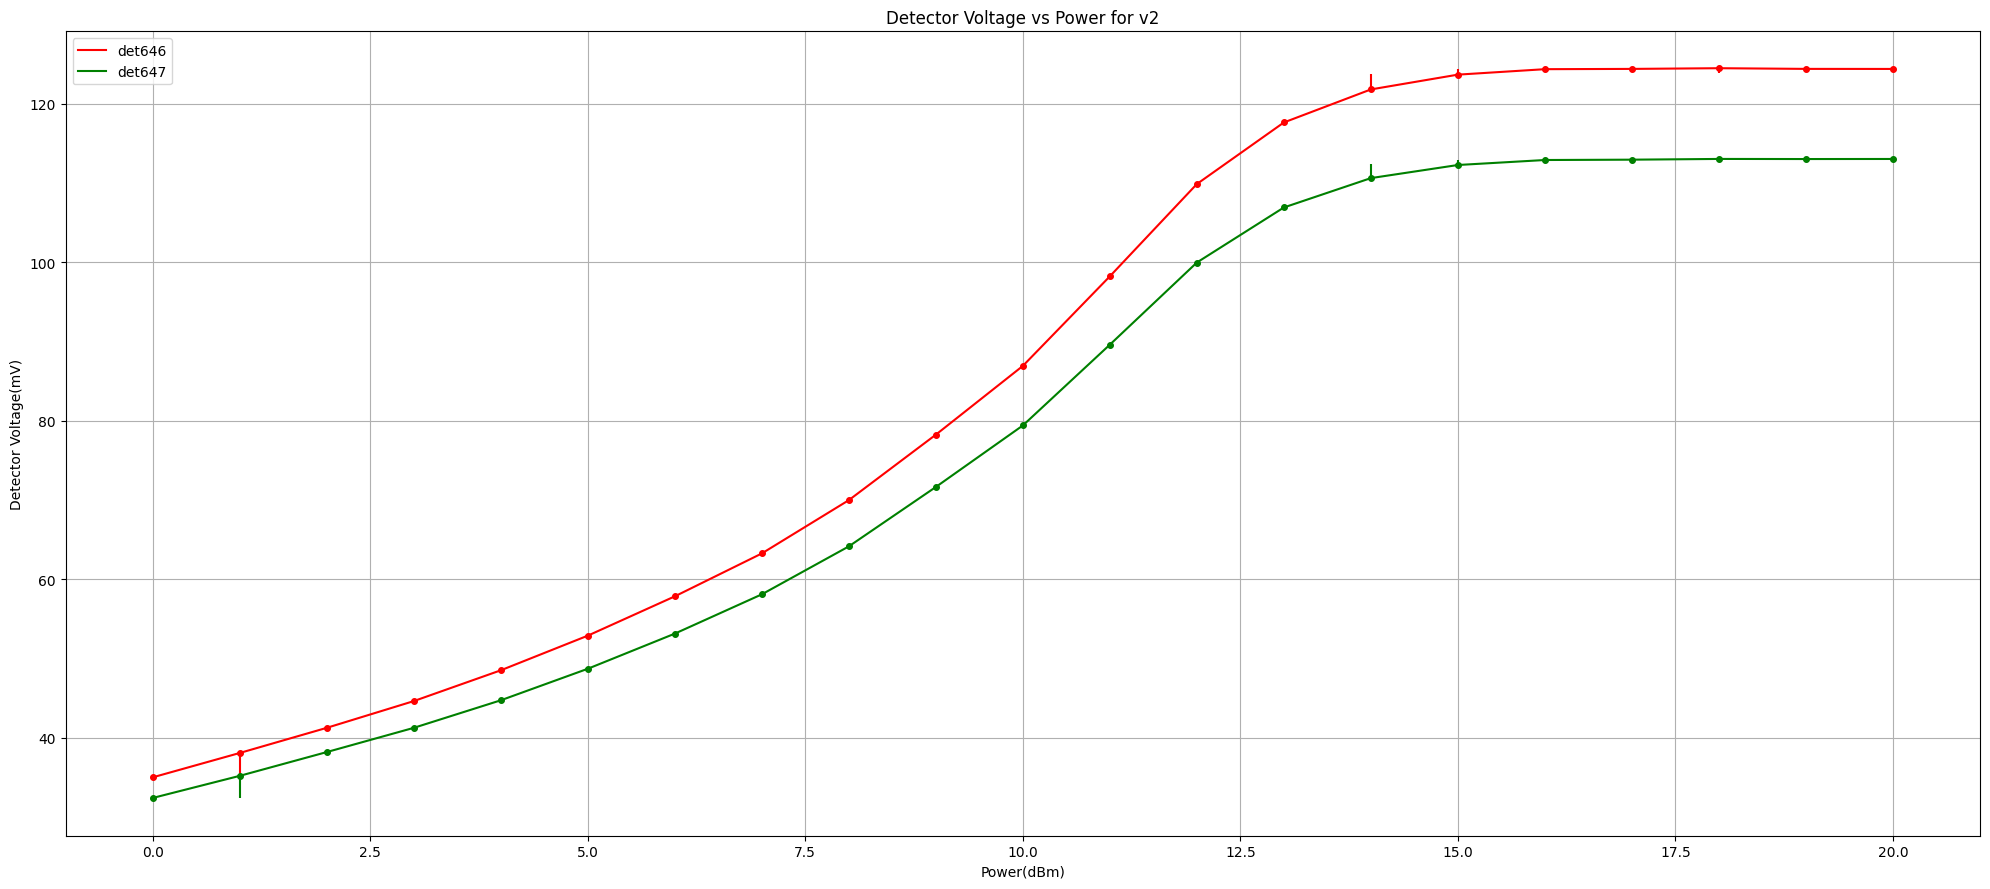

In [14]:
Powerv2 = PowerSeriesPlot(ver='v2', sampling_freq=100, n=400000, aperture=500e-6, info = [0,20,1,18,10], Mod=10, Shift=-10, figsize=(20,9), size=4, normalized=False, detectors=[0,1,1,0])

In [15]:
#Mod = 10
#Shift = -20
#detectors = [0,1,1,0]

In [16]:
#646 v3 start 10:37 8/1/24 no atten basic 100Hz sample 500us aperture 10s 18per -10-20-0.25 Sweep Once
#647 v3 start 12:01 8/1/24 no atten basic 100Hz sample 500us aperture 10s 18per -10-20-0.25 Sweep Once
#645 v3 start 13:29 8/1/24 no atten basic 100Hz sample 500us aperture 10s 18per -10-20-0.25 Sweep Once
#648 v3 start 15:01 8/1/24 no atten basic 100Hz sample 500us aperture 10s 18per -10-20-0.25 Sweep Once

This plot shows all the detector curves in the highest accuracy seen

There are 500000 Points In Total
There are 4000 Points Per Value
The Sampling Rate is 100Hz
The Power Range is -10-20dBm
The Power Increment is 0.25dBm
The Steps Per Increment is 4
The Averaging Point Margin is 10
The Length of Each Step is 10s
The Aperture Length is 500 μs
The Signal Is Not Normalized



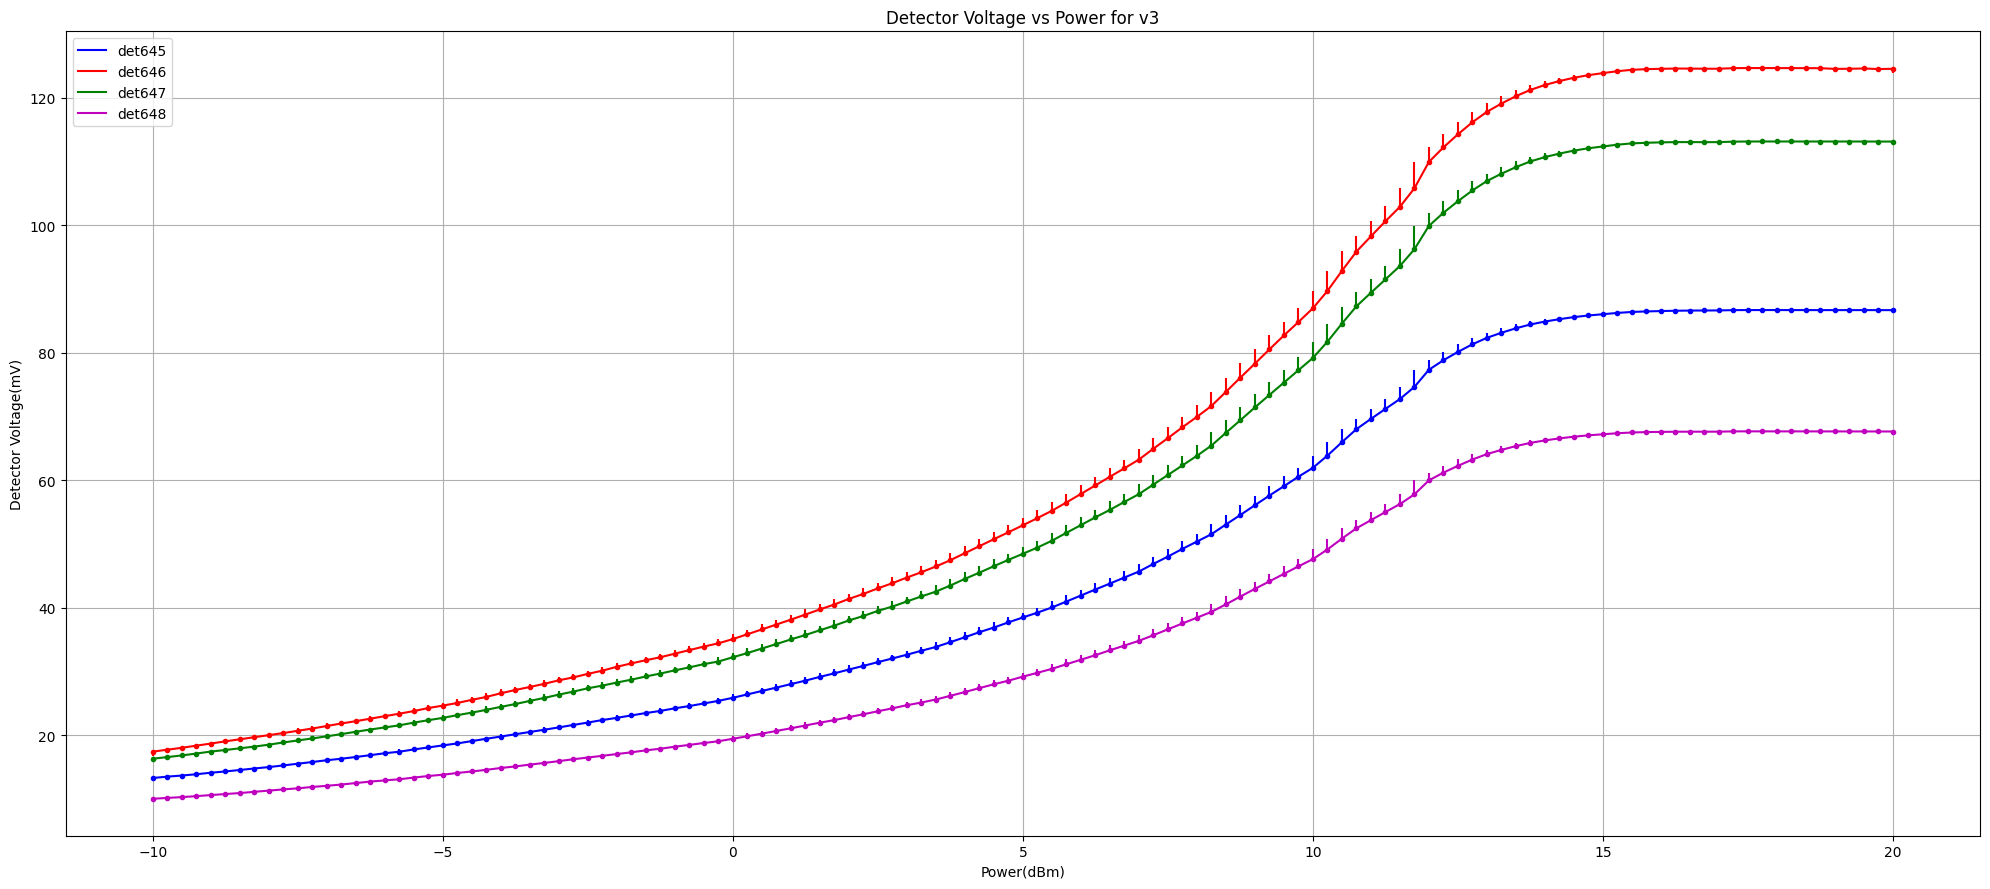

In [17]:
Powerv3 = PowerSeriesPlot(ver='v3', sampling_freq=100, n=500000, aperture=500e-6, info = [-10,20,0.25,4,10], Mod=10, Shift=10, figsize=(20,9), size=2, normalized=False, detectors=[1,1,1,1])

In [18]:
#Add ratio subplot?
#Add Automatic fitting and maybe a fit domain comparison?